In [1]:
from DataManager import CALFData, collateGCN
import numpy as np
import torch 
from Model import ContextAwareModel
from helpers.loss import ContextAwareLoss, SpottingLoss
from train import trainer
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
from Visualiser import collateVisGCN, Visualiser

In [2]:
@dataclass
class Args:
    receptive_field = 10
    framerate = 5
    chunks_per_epoch = 1824
    class_split = "alive"
    num_detections = 15
    chunk_size = 60
    batch_size = 32
    input_channel = 10
    feature_multiplier=1
    backbone_player = "GCN"
    max_epochs=180
    load_weights=None
    model_name="Testing_Model"
    evaluation_frequency=20
    dim_capsule=16
    lambda_coord=5.0
    lambda_noobj=0.5
    loss_weight_segmentation=1.0
    loss_weight_detection=0.0
    patience=25
    LR=1e-03
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    annotation_nr = 8
    K_parameters = torch.FloatTensor([
                                    [-10,-20,-20,-10,-20,-10,-10,-20], 
                                    [-5,-10,-10,-5,-10,-5,-5,-10], 
                                    [5,10,10,5,10,5,5,10], 
                                    [10,20,20,10,20,10,10,20]
                                    ])

# Load Data

In [ ]:
args = Args
collate_fn = collateGCN

train_dataset = CALFData(split="train", args=args)
validation_dataset = CALFData(split="validate", args=args)

train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

validate_loader = torch.utils.data.DataLoader(validation_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

# Grid Search Train 

In [10]:
for i, chunk_size in enumerate(np.arange(10,60,10)):

    # Set manually parameters 
    receptive_field = 0.2 * chunk_size

    K_vals = [
        (0.2*chunk_size, 0.1*chunk_size),
        (0.4*chunk_size, 0.2*chunk_size),
        (0.4*chunk_size, 0.2*chunk_size),
        (0.2*chunk_size, 0.1*chunk_size),
        (0.4*chunk_size, 0.2*chunk_size),
        (0.2*chunk_size, 0.1*chunk_size),
        (0.2*chunk_size, 0.1*chunk_size),
        (0.4*chunk_size, 0.2*chunk_size),
        ]
    
    K_LIST = []
    for K in range(4):
        # multiplier = -1 if K in range(2) else 1
        if K==0:
            list_param = [-K_vals[ann][0] for ann in range(len(K_vals))]
        elif K==1:
            list_param = [-K_vals[ann][1] for ann in range(len(K_vals))]
        elif K==2:
            list_param = [K_vals[ann][0] for ann in range(len(K_vals))]
        else:
            list_param = [K_vals[ann][1] for ann in range(len(K_vals))]
        K_LIST.append(list_param)

    K_PARAMS = torch.FloatTensor(K_LIST)

    args.K_parameters = K_PARAMS
    args.chunk_size = chunk_size
    args.receptive_field = receptive_field

    model = ContextAwareModel(num_classes=args.annotation_nr, args=args)
    criterion_segmentation = ContextAwareLoss(K=train_dataset.K_parameters)
    criterion_spotting = SpottingLoss(lambda_coord=args.lambda_coord, lambda_noobj=args.lambda_noobj)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                                betas=(0.9, 0.999), eps=1e-07, 
                                weight_decay=0, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

    losses = trainer(train_loader, validate_loader,
                        model, optimizer, scheduler, 
                        [criterion_segmentation, criterion_spotting], 
                        [args.loss_weight_segmentation, args.loss_weight_detection],
                        model_name=args.model_name,
                        max_epochs=args.max_epochs, evaluation_frequency=args.evaluation_frequency,
                        save_dir=f"models/gridsearch{i}.pth.tar")

    with open(f'results/gridsearch{i}_results.pkl', 'wb') as file:
        pickle.dump(losses, file)

In [3]:
args = Args
collate_fn = collateVisGCN

mAP_combined = np.empty((0,args.annotation_nr))

for i in range(6):
    model_path = f"models/detector{i+1}.pth.tar"
    model = torch.load(model_path)
    visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True)
    mAP = mAP = visualiser.calculate_MAP()
    mAP_combined = np.concatenate((mAP_combined, mAP), axis=0)


Data preprocessing: 100%|██████████| 1/1 [00:14<00:00, 14.48s/it]


Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.55s/it]


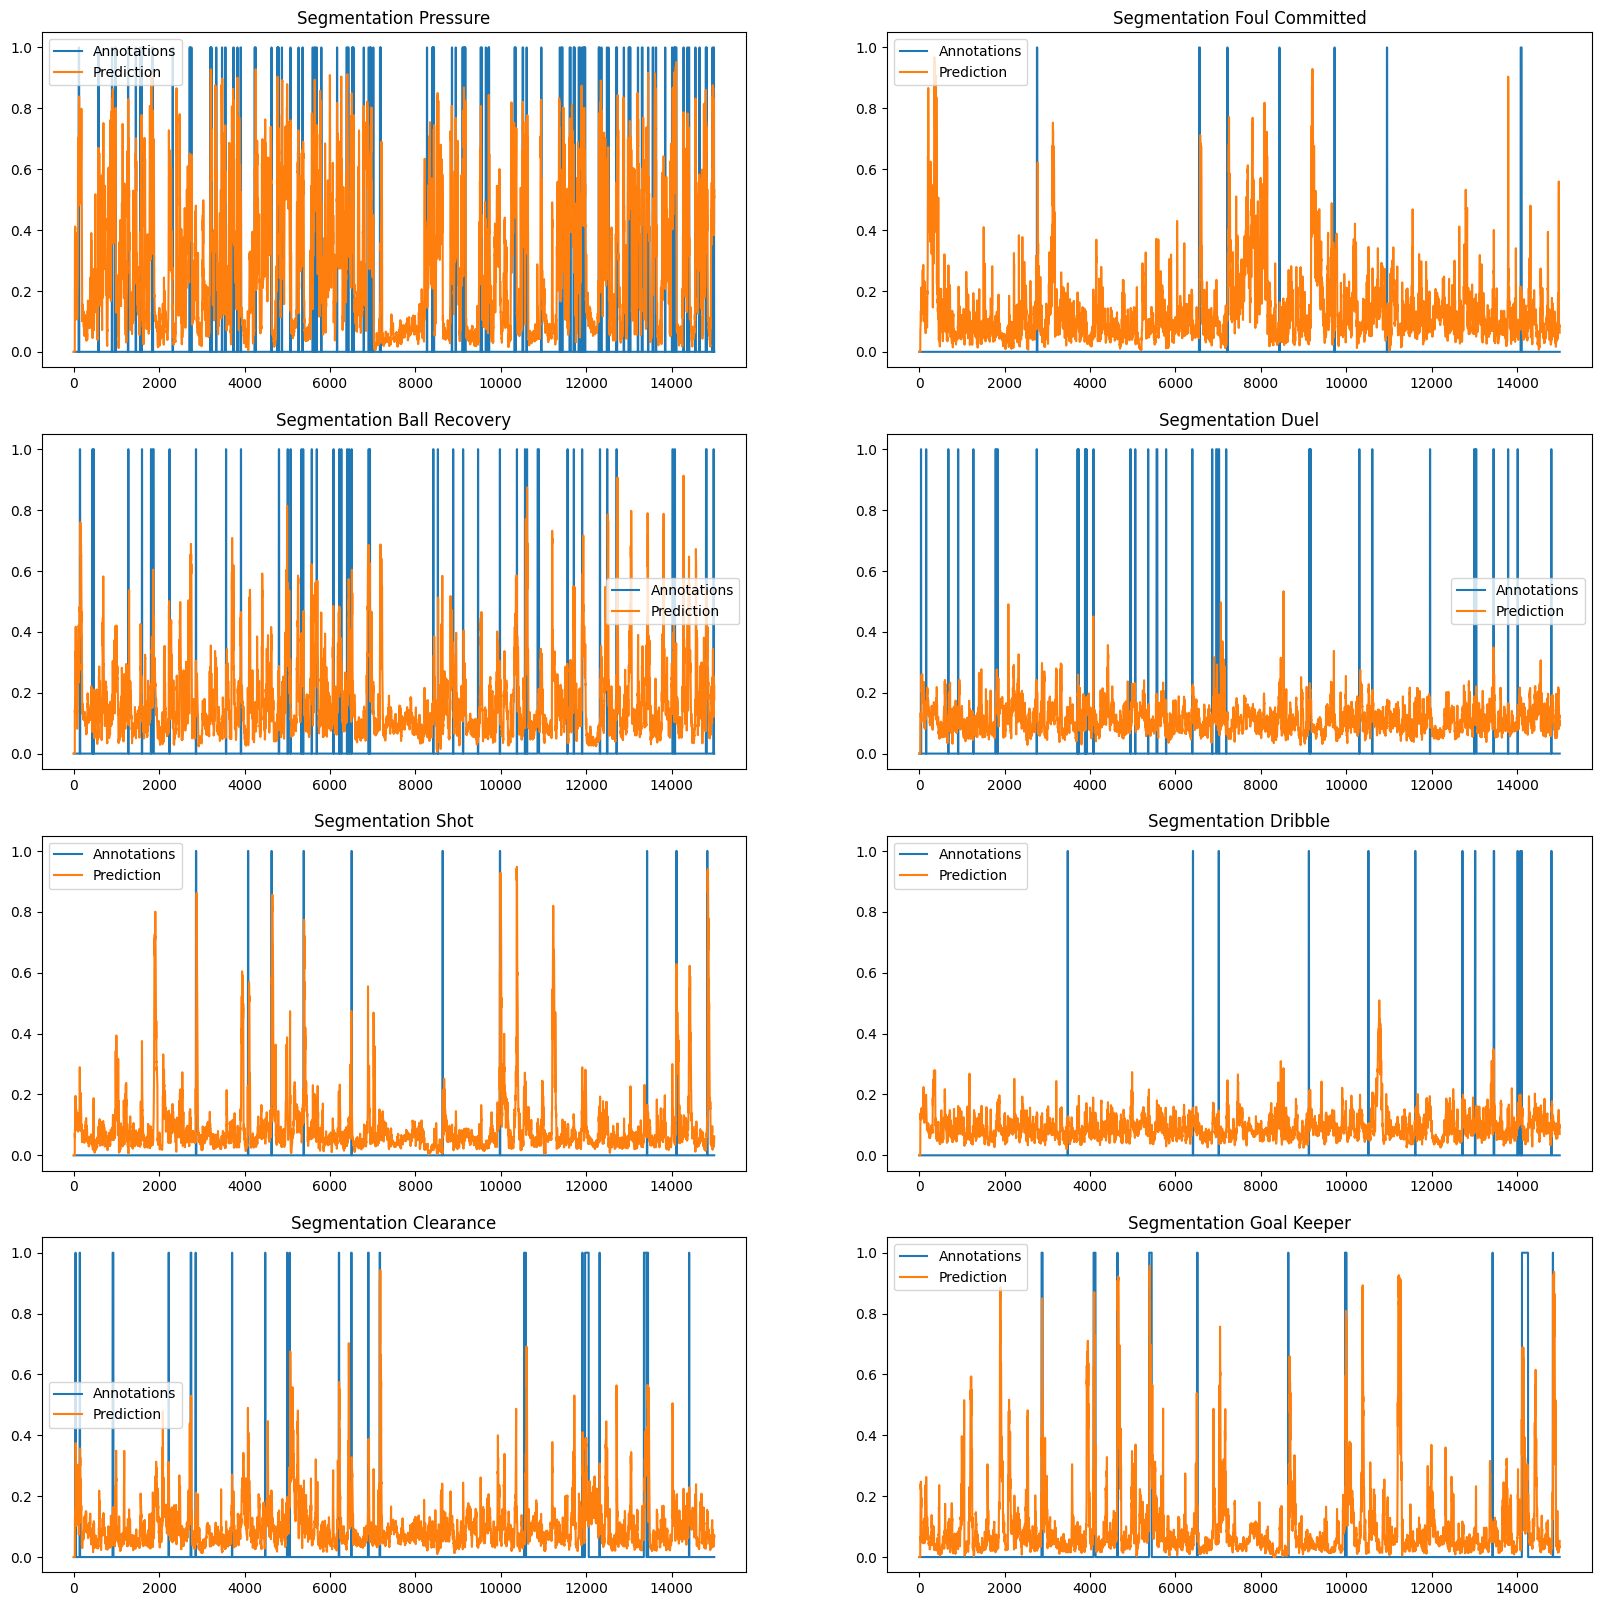

In [10]:
args = Args
collate_fn = collateVisGCN
model_path = f"models/detector{3}.pth.tar"
model = torch.load(model_path)
visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True)
visualiser.plot_predictions(frame_threshold=15000, save_dir=None, annotation=None)

In [11]:
visualiser.calculate_MAP()

array([0.09360162, 0.2512018 , 0.02611203, 0.05986368, 0.0446057 ,
       0.02189642, 0.0393215 , 0.10229498, 0.20351686])